In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sep
import pandas as pd
import os
from astropy.table import Table, vstack

In [ ]:
from maddeb.utils import listdir_fullpath, get_data_dir_path

In [ ]:
logging.basicConfig(format="%(message)s", level=logging.INFO)
LOG = logging.getLogger(__name__)

## load the saved results

In [ ]:
density_level = "high"

In [ ]:
data_path = "/sps/lsst/users/bbiswas/MADNESS_results/" + density_level + "_density"
run_name = "kl01" # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [ ]:
madness_results=[]
scarlet_results=[]
actual_photometry = []
blended_photometry = []

for file_num in range(300):

    madness_results.append(pd.read_pickle(os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")))
    scarlet_results.append(pd.read_pickle(os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")))

    actual_photometry.append(pd.read_pickle(os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")))
    blended_photometry.append(pd.read_pickle(os.path.join(data_path, "blended_photometry",  str(file_num) + ".pkl")))

madness_results = pd.concat(madness_results)
scarlet_results = pd.concat(scarlet_results)

actual_photometry = pd.concat(actual_photometry)
blended_photometry = pd.concat(blended_photometry)

In [ ]:
mask=madness_results["r_contamination"].values<5
madness_results=madness_results[mask]
scarlet_results=scarlet_results[mask]
actual_photometry=actual_photometry[mask]
blended_photometry=blended_photometry[mask]

# Pixel Covariance

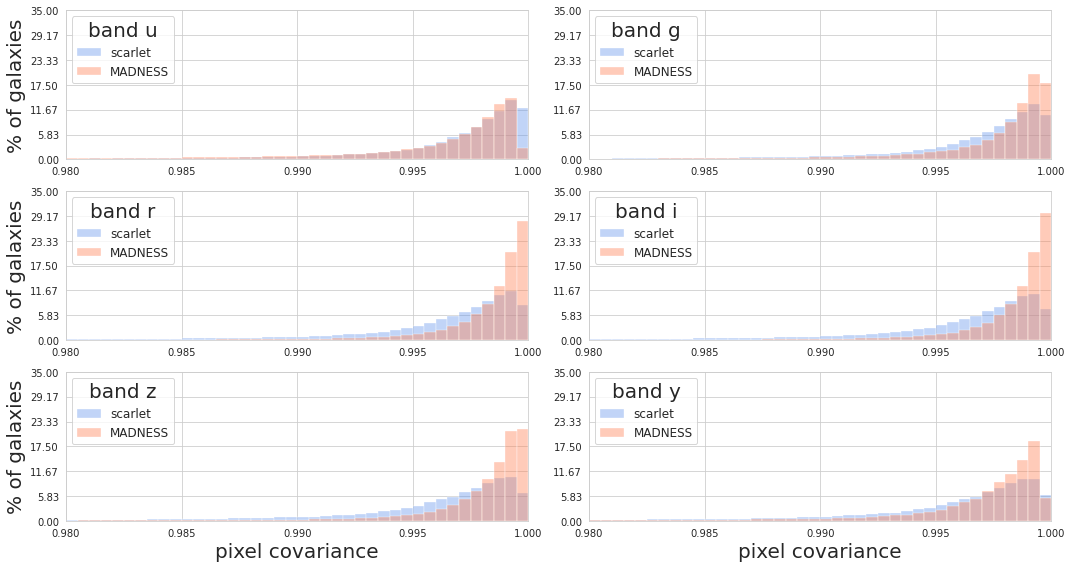

In [ ]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(3, 2, figsize=(15,8))
bins = np.arange(0.95, 1, 0.0005)
for band_number, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    #print(band_number)
    cov_band = band
    ax = axs[int(band_number/2), band_number%2]
    sns.histplot(x=scarlet_results[cov_band + '_covariance'].values, ax=ax,bins=bins, alpha=0.4, label="scarlet", stat='percent', color="cornflowerblue")
    sns.histplot(x=madness_results[cov_band + '_covariance'].values, ax=ax,bins=bins, alpha=0.4, label="MADNESS", stat='percent', color="coral")
    ax.legend()
    ax.set_xlim([0.98, 1])
    ax.set_xticks(np.linspace(.98,1.0,5,endpoint=True), fontsize=20)
    ax.set_yticks(np.linspace(0,35,7), fontsize=20)
    #axs[band_number].set_xlabel("pixel covariance", fontsize=20)
    if band_number % 2 ==0:
        ax.set_ylabel("% of galaxies", fontsize=20)
    else:
        ax.set_ylabel("")
    # ax.set_ylabel("% of galaxies", fontsize=20)
    ax.legend(fontsize=12, title="band " + band, loc="upper left", title_fontsize=20)
    #ax = plt.gca()
    #axs[band_number].tight_layout()
    #axs[band_num].grid(color='lightgray', linestyle='-', linewidth=2)
    if int(band_number/2) == 2:
        ax.set_xlabel("pixel covariance", fontsize=20)
plt.tight_layout()
plt.savefig("results/" + density_level + "_density/" + density_level + "_density_cov_res.png")
plt.savefig("results/" + density_level + "_density/" + density_level + "_density_cov_res.pdf")
plt.show()

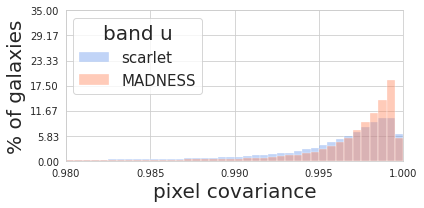

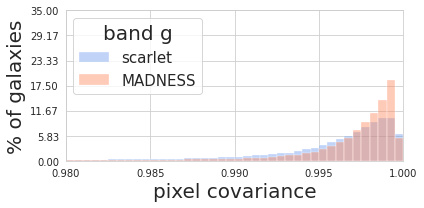

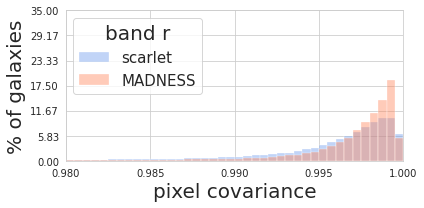

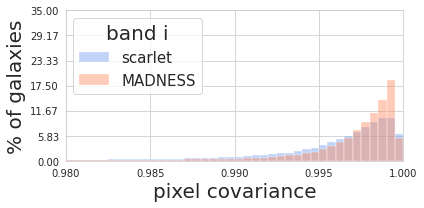

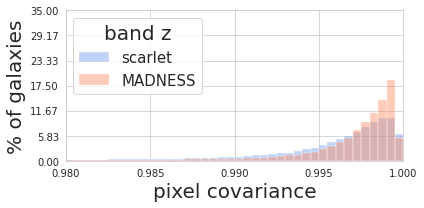

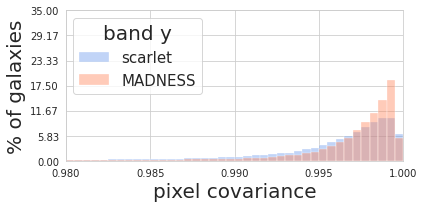

In [ ]:
#fig, axs = plt.subplots(6, 1, figsize=(6,20))
bins = np.arange(0.95, 1, 0.0005)
for band_number, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(6,3))
    axs=plt.gca()
    axs=plt.gca()
    sns.histplot(x=scarlet_results[cov_band + '_covariance'].values, ax=axs, bins=bins, alpha=0.4, label="scarlet", stat='percent', color="cornflowerblue")
    sns.histplot(x=madness_results[cov_band + '_covariance'].values, ax=axs, bins=bins, alpha=0.4, label="MADNESS", stat='percent', color="coral")
    axs.legend()
    axs.set_xlim([0.98, 1])
    axs.set_xticks(np.linspace(.98,1.0,5,endpoint=True), fontsize=18)
    axs.set_yticks(np.linspace(0,35,7), fontsize=18)
    axs.set_xlabel("pixel covariance", fontsize=20)
    axs.set_ylabel("% of galaxies", fontsize=20)
    axs.legend(fontsize=15, title="band " + band, loc="upper left", title_fontsize=20)
    #ax = plt.gca()
    #axs[band_number].tight_layout()
    #axs[band_num].grid(color='lightgray', linestyle='-', linewidth=2)
    plt.tight_layout()
    plt.savefig("results/" + density_level + "_density/" + density_level + "_density_" + band + "_cov_res.png")
    plt.savefig("results/" + density_level + "_density/" + density_level + "_density_" + band + "_cov_res.pdf")
    plt.show()

# Relative error in apperture photometry errors (r = 5)

In [ ]:
def gauss(x, sig, mu, a):
    return 1/np.sqrt(2.*np.pi)/sig*np.exp(-0.5*(x-mu)**2/sig**2)

In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import norm

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[-2.5   -2.495 -2.49  ...  2.49   2.495  2.5  ]


Madness mu: -0.024846888794455277
Madness sig: 0.1742778384751753
Scarlet mu: 0.001403017641005318
Scarlet sig: 0.1919722629015861


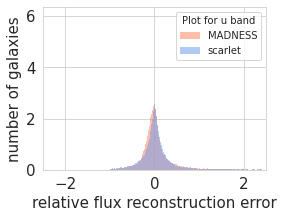

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[-2.5   -2.495 -2.49  ...  2.49   2.495  2.5  ]


Madness mu: -0.026316477124507427
Madness sig: 0.07758133181718738
Scarlet mu: 0.004389863812980105
Scarlet sig: 0.08621165096353194


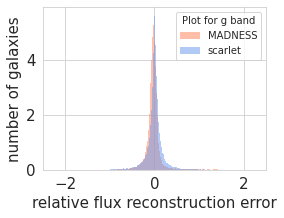

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[-2.5   -2.495 -2.49  ...  2.49   2.495  2.5  ]


Madness mu: -0.007257758326309698
Madness sig: 0.06866198892424559
Scarlet mu: 0.006204155098598371
Scarlet sig: 0.06976771873599183


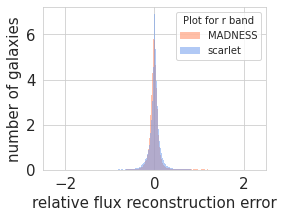

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[-2.5   -2.495 -2.49  ...  2.49   2.495  2.5  ]


Madness mu: -0.02441396104477523
Madness sig: 0.07739606128398172
Scarlet mu: 0.007724778495027913
Scarlet sig: 0.07352845222164969


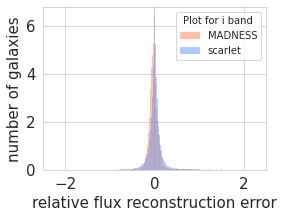

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[-2.5   -2.495 -2.49  ...  2.49   2.495  2.5  ]


Madness mu: -0.017715630144358268
Madness sig: 0.07795927341303834
Scarlet mu: 0.0074971413954880535
Scarlet sig: 0.0920194440114728


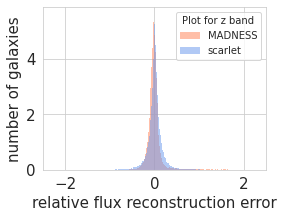

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[-2.5   -2.495 -2.49  ...  2.49   2.495  2.5  ]


Madness mu: -0.012991780678219286
Madness sig: 0.13624570391990734
Scarlet mu: 0.004280678961354875
Scarlet sig: 0.1415076645617433


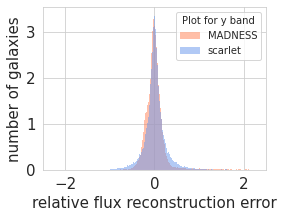

In [ ]:
for band_number, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):

    madness_actual_flux = madness_results[band+"_actual_flux"].values
    madness_predicted_flux = madness_results[band+"_predicted_flux"].values

    scarlet_actual_flux = scarlet_results[band+"_actual_flux"].values
    scarlet_predicted_flux = scarlet_results[band+"_predicted_flux"].values

    scarlet_relative_difference = np.divide(
        scarlet_predicted_flux - scarlet_actual_flux, scarlet_actual_flux
    )
    madness_relative_difference = np.divide(
        madness_predicted_flux - madness_actual_flux, madness_actual_flux
    )
    
    n_bins = 1000

    hist, bin_tmp = np.histogram(a=madness_relative_difference, bins=n_bins, range=(-2.5,2.5), density=True)
    bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
    madness_fit = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins), 10])
    print(bin_tmp)

    hist, bin_tmp = np.histogram(a=scarlet_relative_difference, bins=n_bins, range=(-2.5,2.5), density=True)
    bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
    scarlet_fit = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins), 10])
    
#     sns.set_theme(style={"axes.grid": True,
#                      'axes.labelcolor': 'black',
#                      'figure.facecolor': '1.',
#                      'xtick.color': 'black',
#                      'ytick.color': 'black',
#                      'text.color': 'black',
#                      'image.cmap': 'viridis',})
    plt.figure(figsize=(4, 3))
    bins = np.arange(-5, 5, 0.01)
    sns.histplot(
        x = madness_relative_difference[
            np.logical_not(np.isnan(madness_relative_difference))
        ].reshape(-1),
        bins=bins,
        kde=False,
        alpha=0.5,
        stat="density",
        color="coral",
        label="MADNESS",
    )
#     plt.plot(bins, gauss(bins, *madness_fit[0]), color="coral")
    LOG.info("Madness mu: " + str(madness_fit[0][1]))
    LOG.info("Madness sig: " + str(madness_fit[0][0]))
    sns.histplot(
        x = scarlet_relative_difference[
            np.logical_not(np.isnan(scarlet_relative_difference))
        ].reshape(-1),
        bins=bins,
        kde=False,
        alpha=0.5,
        stat="density",
        color="cornflowerblue",
        label="scarlet",
    )
#     plt.plot(
#         bins, gauss(bins, scarlet_fit[0][0], scarlet_fit[0][1], scarlet_fit[0][2]), color="cornflowerblue"
#     )
    LOG.info("Scarlet mu: " + str(scarlet_fit[0][1]))
    LOG.info("Scarlet sig: " + str(scarlet_fit[0][0]))
    plt.legend(fontsize=10, title = "Plot for " + band + " band")
    ax = plt.gca()
    plt.xlabel("relative flux reconstruction error", fontsize=15)
    ax.tick_params(labelsize=15)
    plt.ylabel("number of galaxies", fontsize=15)
    plt.xlim([-2.5, 2.5])
    plt.show()

# Compare apperture photometry

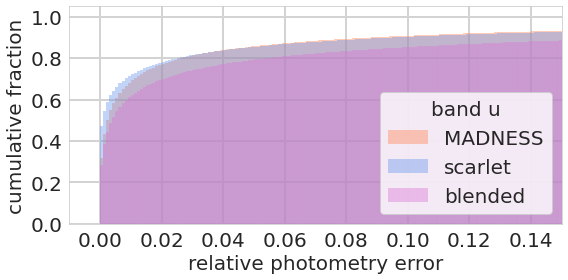

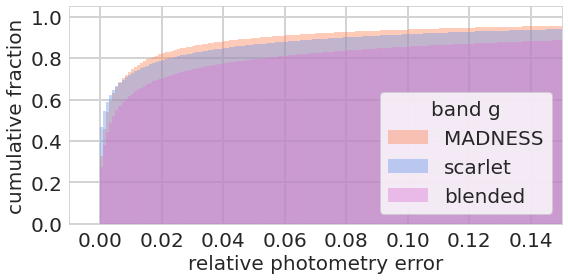

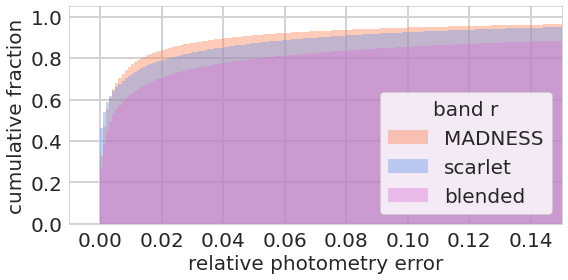

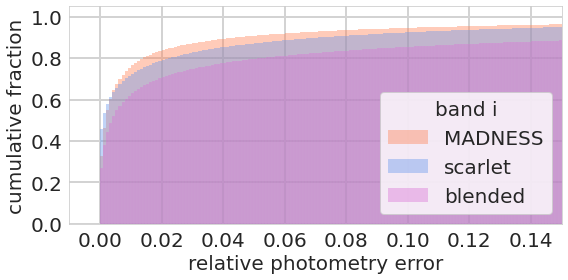

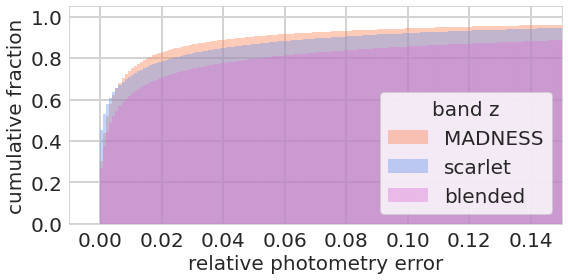

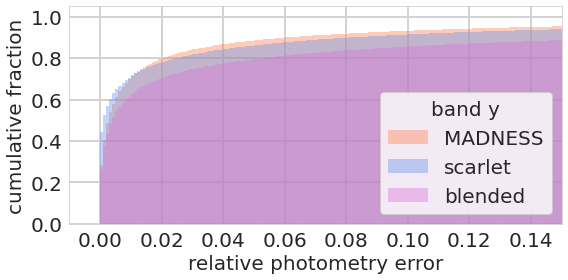

In [ ]:
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    #sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    sns.set_style("whitegrid")
#     sns.set_theme(style={"axes.grid": True,'grid.color': 'black',
# })
    plt.figure(figsize=(8, 4))
    bins = np.arange(-1, 1, 0.001)
    sns.histplot(
        x=np.abs((madness_results[band+"_phot_flux"].values - actual_photometry[band+"_phot_flux"].values) / actual_photometry[band+"_phot_flux"].values),
        bins=bins,
        alpha=0.4,
        stat='density',
        label="MADNESS",
        cumulative=True,
        color="coral",
    )

    sns.histplot(
        x=np.abs((scarlet_results[band+"_phot_flux"].values - actual_photometry[band+"_phot_flux"].values) / actual_photometry[band+"_phot_flux"].values),
        bins=bins,
        stat="density",
        alpha=0.4,
        label="scarlet",
        cumulative=True,
        color="cornflowerblue",
    )

    sns.histplot(
        x = np.abs((blended_photometry[band+"_phot_flux"].values - actual_photometry[band+"_phot_flux"].values) / actual_photometry[band+"_phot_flux"].values),
        bins=bins,
        alpha=0.4,
        stat='density',
        label="blended",
        cumulative=True,
        color="orchid",
    )
    ax = plt.gca()
    ax.grid(color='lightgray', linestyle='-', linewidth=2)
    plt.xlim([-.01, .15])
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("relative photometry error", fontsize=20)
    plt.ylabel("cumulative fraction", fontsize=20)
    plt.legend(fontsize=20, title="band " + band, loc="lower right", title_fontsize=20)
    plt.tight_layout()
    plt.savefig("results/"+ density_level + "_density/cumulative_distib_phot_err_"+band)
    plt.savefig("results/"+ density_level + "_density/cumulative_distib_phot_err_"+band + ".pdf", format="pdf", bbox_inches="tight")
    plt.show()

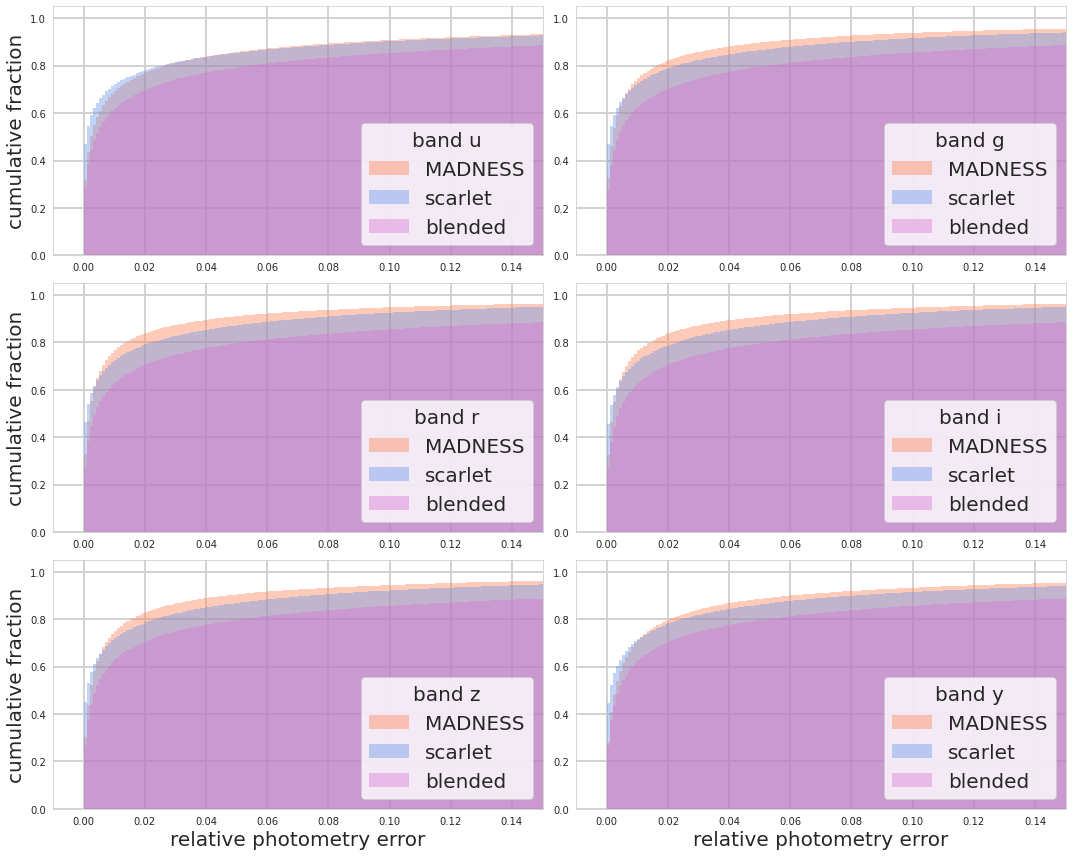

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15,12))
for band_num, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    #sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    sns.set_style("whitegrid")
#     sns.set_theme(style={"axes.grid": True,'grid.color': 'black',
# })
    # plt.figure(figsize=(8, 4))
    ax = axs[int(band_num/2), band_num%2]
    bins = np.arange(-1, 1, 0.001)
    sns.histplot(
        x=np.abs((madness_results[band+"_phot_flux"].values - actual_photometry[band+"_phot_flux"].values) / actual_photometry[band+"_phot_flux"].values),
        bins=bins,
        alpha=0.4,
        stat='density',
        label="MADNESS",
        cumulative=True,
        color="coral",
        ax=ax,
    )

    sns.histplot(
        x=np.abs((scarlet_results[band+"_phot_flux"].values - actual_photometry[band+"_phot_flux"].values) / actual_photometry[band+"_phot_flux"].values),
        bins=bins,
        stat="density",
        alpha=0.4,
        label="scarlet",
        cumulative=True,
        color="cornflowerblue",
        ax=ax,
    )

    sns.histplot(
        x = np.abs((blended_photometry[band+"_phot_flux"].values - actual_photometry[band+"_phot_flux"].values) / actual_photometry[band+"_phot_flux"].values),
        bins=bins,
        alpha=0.4,
        stat='density',
        label="blended",
        cumulative=True,
        color="orchid",
        ax=ax,
    )
    #ax = plt.gca()
    ax.grid(color='lightgray', linestyle='-', linewidth=2)
    ax.set_xlim([-.01, .15])
    ax.set_xticks(np.linspace(0, .14, 8), fontsize=20)
    ax.set_yticks(np.linspace(0, 1, 6), fontsize=20)
    if int(band_num/2) == 2:
        ax.set_xlabel("relative photometry error", fontsize=20)
    else:
        ax.set_xlabel("")
    
    if band_num %2 ==0:
        ax.set_ylabel("cumulative fraction", fontsize=20)
    else:
        ax.set_ylabel("")

    ax.legend(fontsize=20, title="band " + band, loc="lower right", title_fontsize=20)
plt.tight_layout()
plt.savefig("results/"+ density_level + "_density/cumulative_distib_phot_err")
plt.savefig("results/"+ density_level + "_density/cumulative_distib_phot_err.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Box plots

SNR definition here is one used to place the SNR>10 cut on the catalog.

In [ ]:
boxplot_flux_err_df = {}

boxplot_flux_err_df["snr"] = list(madness_results['r_band_snr'])
boxplot_flux_err_df['r_blendedness'] = list(madness_results['r_blendedness'])
boxplot_flux_err_df['r_contamination'] = list(madness_results['r_contamination'])
boxplot_flux_err_df["type"] = ["madness"] * len(madness_results['size'])
boxplot_flux_err_df["r_relative_flux_err"] = list(np.abs((madness_results["r_phot_flux"].values - actual_photometry["r_phot_flux"].values)) / actual_photometry["r_phot_flux"].values)

boxplot_flux_err_df["snr"].extend(list(scarlet_results['r_band_snr']))
boxplot_flux_err_df['r_blendedness'].extend(list(scarlet_results['r_blendedness']))
boxplot_flux_err_df['r_contamination'].extend(list(madness_results['r_contamination']))
boxplot_flux_err_df["type"].extend(["scarlet"] * len(scarlet_results['size']))
boxplot_flux_err_df["r_relative_flux_err"].extend(list(np.abs((scarlet_results["r_phot_flux"].values - actual_photometry["r_phot_flux"].values)) / actual_photometry["r_phot_flux"].values)) 

boxplot_flux_err_df = pd.DataFrame(boxplot_flux_err_df)

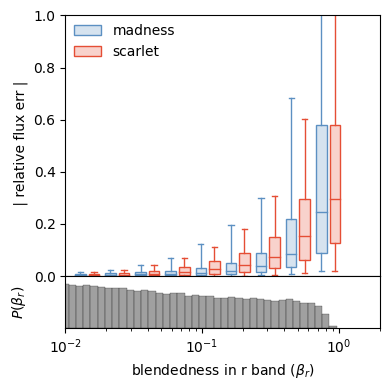

In [ ]:
import maddeb.boxplot
import matplotlib as mpl

fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_flux_err_df,
    x = "r_blendedness", y = "r_relative_flux_err", z = "type",
    xlim = (1e-2, 2),
    ylim = (-0, 1.0), 
    x_scale = 'log',
    legend = ['madness', 'scarlet'],
    x_label=r'blendedness in r band ($\beta_r$)', 
    y_label = ' | relative flux err |',
    y_label_hist=r'$P(\beta_r)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10,
)
plt.savefig(os.path.join("results", density_level + "_density", "blendedness_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "blendedness_box_plot.png"))

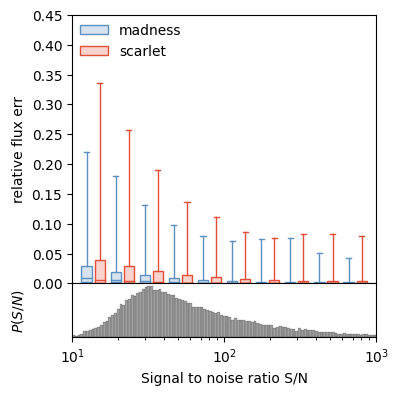

In [ ]:
fig, median_fluxerr, q1_fluxerr, q3_fluxerr, whislo_fluxerr, whishi_fluxerr = maddeb.boxplot.boxplot_func(
    boxplot_flux_err_df, 
    x = 'snr', y = "r_relative_flux_err", z = "type",
    xlim = (10, 1000),
    ylim = (-0, 0.45), 
    x_scale = 'log',
    legend = ['madness', 'scarlet'],
    x_label='Signal to noise ratio S/N', 
    y_label = 'relative flux err',
    y_label_hist=r'$P(S/N)$',
    legend_remove = False,
    whis = [5,95],
    percents = [25,75],
    palette = mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10
)

plt.savefig(os.path.join("results", density_level + "_density", "snr_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "snr_box_plot.png"))

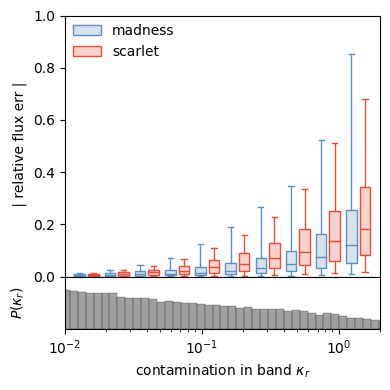

In [ ]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_flux_err_df, 
    x = 'r_contamination', y = "r_relative_flux_err", z = "type",
    xlim = (1e-2, 2),
    ylim = (-0, 1), 
    x_scale = 'log',
    legend = ['madness', 'scarlet'],
    x_label=r'contamination in band $\kappa_r$', 
    y_label = ' | relative flux err |',
    y_label_hist=r'$P(\kappa_r)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10,
)
plt.savefig(os.path.join("results", density_level + "_density", "contamination_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "contamination_box_plot.png"))

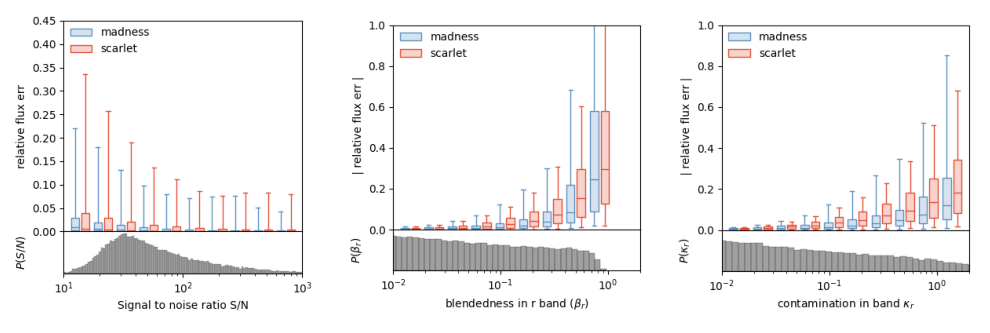

In [ ]:
import matplotlib.image as mpimg

f, axarr = plt.subplots(1, 3, figsize=(10, 15))

#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "snr_box_plot.png")))
axarr[1].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "blendedness_box_plot.png")))
axarr[2].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "contamination_box_plot.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout()

plt.savefig("results/" + density_level + "_density/" + density_level + "_density_boxplot_results.pdf", format="pdf", bbox_inches="tight")
plt.savefig("results/" + density_level + "_density/" + density_level + "_density_boxplot_results.png")

plt.show()

# color plots

In [ ]:
import astropy.units as u
import galcheat

In [ ]:
survey = galcheat.helpers.get_survey("LSST")
for band in ["u", "g", "r", "i", "y", "z"]:

    exp_time = survey.get_filter(band).full_exposure_time

    actual_phot_mag = actual_photometry[f"{band}_phot_flux"].values
    z_point = survey.get_filter(band).zeropoint
    
    actual_photometry[f"{band}_phot_mag"] = ((actual_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) 
     + z_point).value
    
    madness_phot_mag = madness_results[f"{band}_phot_flux"].values
    madness_results[f"{band}_phot_mag"] = ((madness_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) 
     + z_point ).value
    
    scarlet_phot_mag = scarlet_results[f"{band}_phot_flux"].values
    scarlet_results[f"{band}_phot_mag"] = ((scarlet_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) 
     + z_point).value

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units

In [ ]:
actual_color = actual_photometry["g_phot_mag"] - actual_photometry["r_phot_mag"]
madness_results['gr_color'] = madness_results["g_phot_mag"] - madness_results["r_phot_mag"]
scarlet_results['gr_color'] = scarlet_results["g_phot_mag"] - scarlet_results["r_phot_mag"]

In [ ]:
boxplot_color_df = {}

boxplot_color_df["snr"] = list(madness_results['r_band_snr'])
boxplot_color_df['r_blendedness'] = list(madness_results['r_blendedness'])
boxplot_color_df['r_contamination'] = list(madness_results['r_contamination'])
boxplot_color_df["type"] = ["madness"] * len(madness_results['size'])
boxplot_color_df['gr_color_err'] = list(madness_results['gr_color'].values-actual_color.values)
boxplot_color_df['gr_actual'] = list(actual_color.values)

boxplot_color_df["snr"].extend(list(scarlet_results['r_band_snr']))
boxplot_color_df['r_blendedness'].extend(list(scarlet_results['r_blendedness']))
boxplot_color_df['r_contamination'].extend(list(madness_results['r_contamination']))
boxplot_color_df["type"].extend(["scarlet"] * len(scarlet_results['size']))
boxplot_color_df['gr_color_err'].extend(list(scarlet_results['gr_color'].values-actual_color.values))
boxplot_color_df['gr_actual'].extend(list(actual_color.values))

boxplot_color_df = pd.DataFrame(boxplot_color_df)

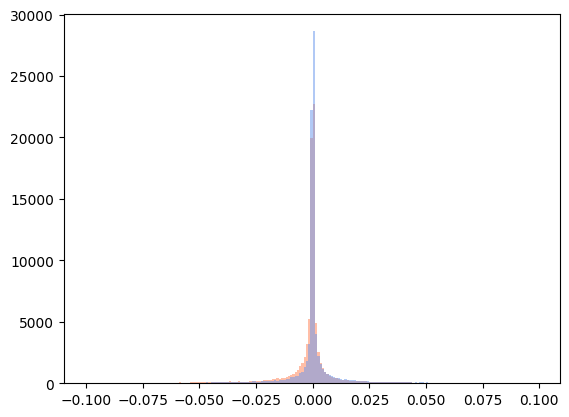

In [ ]:
plt.hist(madness_results['gr_color']-actual_color.values, bins=np.arange(-.1, .1, .001), alpha=.5, color="coral");
plt.hist(scarlet_results['gr_color']-actual_color.values, bins=np.arange(-.1, .1, .001), alpha=.5, color="cornflowerblue");

In [ ]:
madness_results.columns

Index(['u_covariance', 'u_actual_flux', 'u_predicted_flux', 'u_blendedness',
       'g_covariance', 'g_actual_flux', 'g_predicted_flux', 'g_blendedness',
       'r_covariance', 'r_actual_flux', 'r_predicted_flux', 'r_blendedness',
       'i_covariance', 'i_actual_flux', 'i_predicted_flux', 'i_blendedness',
       'z_covariance', 'z_actual_flux', 'z_predicted_flux', 'z_blendedness',
       'y_covariance', 'y_actual_flux', 'y_predicted_flux', 'y_blendedness',
       'galaxy_num', 'size', 'field_num', 'file_num', 'r_band_snr', 'ref_mag',
       'u_phot_flux', 'u_phot_fluxerrs', 'u_phot_flags', 'g_phot_flux',
       'g_phot_fluxerrs', 'g_phot_flags', 'r_phot_flux', 'r_phot_fluxerrs',
       'r_phot_flags', 'i_phot_flux', 'i_phot_fluxerrs', 'i_phot_flags',
       'z_phot_flux', 'z_phot_fluxerrs', 'z_phot_flags', 'y_phot_flux',
       'y_phot_fluxerrs', 'y_phot_flags', 'r_contamination', 'u_phot_mag',
       'g_phot_mag', 'r_phot_mag', 'i_phot_mag', 'y_phot_mag', 'z_phot_mag',
       'gr_col

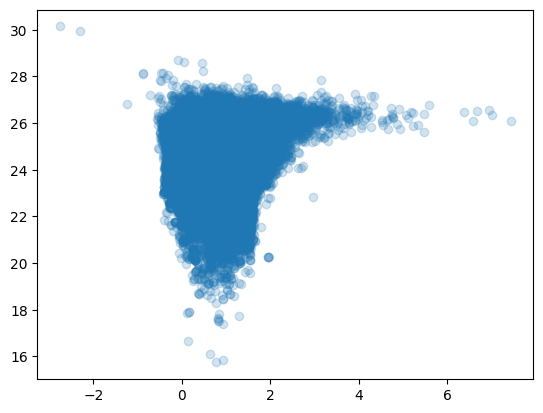

In [ ]:
plt.scatter(actual_color.values, actual_photometry["r_phot_mag"].values, alpha=.2)

<AxesSubplot:ylabel='Density'>

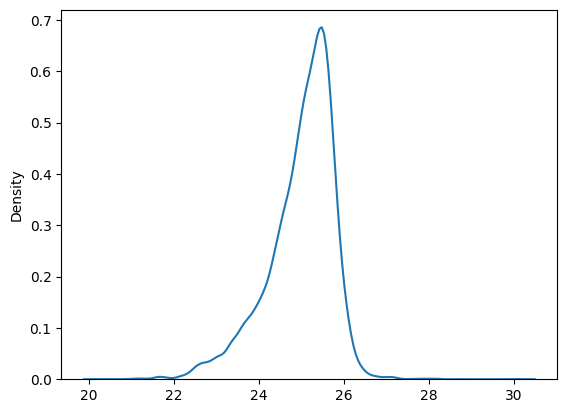

In [ ]:
sns.kdeplot(actual_photometry["r_phot_mag"].values[actual_color.values<0])

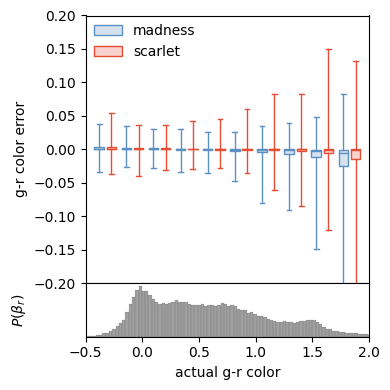

In [ ]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df, 
    x = "gr_actual", y = "gr_color_err", z = "type",
    xlim = (-.5, 2),
    ylim = (-.2, .2), 
    x_scale = None,
    legend = ['madness', 'scarlet'],
    x_label='actual g-r color', 
    y_label = 'g-r color error',
    y_label_hist=r'$P(\beta_r)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10,
)
plt.savefig(os.path.join("results", density_level + "_density", "blendedness_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "blendedness_color_box_plot.png"))

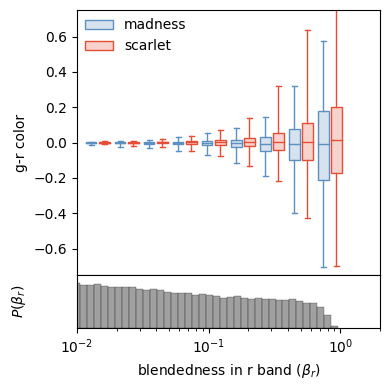

In [ ]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df, 
    x = "r_blendedness", y = "gr_color_err", z = "type",
    xlim = (1e-2, 2),
    ylim = (-.75, .75), 
    x_scale = 'log',
    legend = ['madness', 'scarlet'],
    x_label=r'blendedness in r band ($\beta_r$)', 
    y_label = 'g-r color',
    y_label_hist=r'$P(\beta_r)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10,
)
plt.savefig(os.path.join("results", density_level + "_density", "blendedness_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "blendedness_color_box_plot.png"))

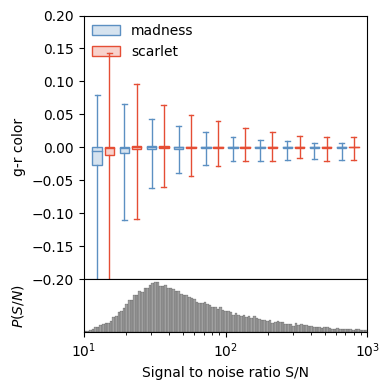

In [ ]:
fig, median_fluxerr, q1_fluxerr, q3_fluxerr, whislo_fluxerr, whishi_fluxerr = maddeb.boxplot.boxplot_func(
    boxplot_color_df, 
    x = 'snr', y = "gr_color_err", z = "type",
    xlim = (10, 1000),
    ylim = (-.2, 0.2), 
    x_scale = 'log',
    legend = ['madness', 'scarlet'],
    x_label='Signal to noise ratio S/N', 
    y_label = 'g-r color',
    y_label_hist=r'$P(S/N)$',
    legend_remove = False,
    whis = [5,95],
    percents = [25,75],
    palette = mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10
)

plt.savefig(os.path.join("results", density_level + "_density", "snr_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "snr_color_box_plot.png"))

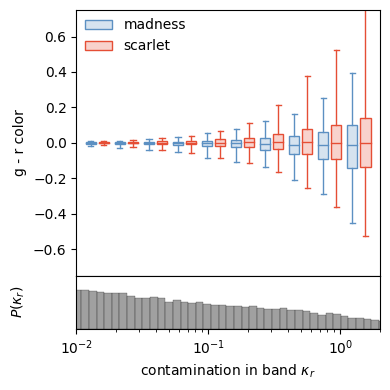

In [ ]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df, 
    x = 'r_contamination', y = "gr_color", z = "type",
    xlim = (1e-2, 2),
    ylim = (-.75, .75), 
    x_scale = 'log',
    legend = ['madness', 'scarlet'],
    x_label=r'contamination in band $\kappa_r$', 
    y_label = 'g - r color',
    y_label_hist=r'$P(\kappa_r)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10,
)
plt.savefig(os.path.join("results", density_level + "_density", "contamination_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "contamination_color_box_plot.png"))

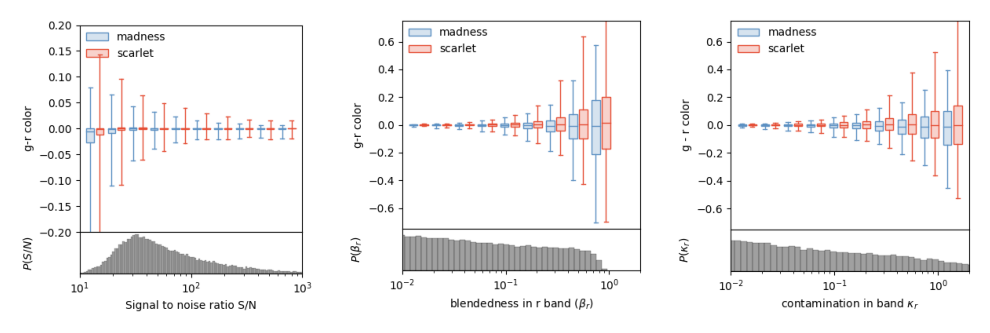

In [ ]:
f, axarr = plt.subplots(1, 3, figsize=(10, 15))

#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "snr_color_box_plot.png")))
axarr[1].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "blendedness_color_box_plot.png")))
axarr[2].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "contamination_color_box_plot.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout()

plt.savefig("results/" + density_level + "_density/" + density_level + "_density_ color_boxplot_results.pdf", format="pdf", bbox_inches="tight")
plt.savefig("results/" + density_level + "_density/" + density_level + "_density_color_boxplot_results.png")

plt.show()

# Validation plots

In [ ]:
snr_blendedness_df = {}
snr_blendedness_df["snr"] = madness_results['r_band_snr']
snr_blendedness_df["blendedness"] = madness_results['r_blendedness']

<AxesSubplot:>

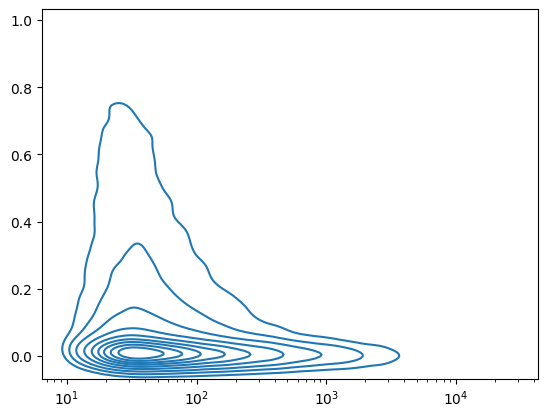

In [ ]:
sns.kdeplot(x=madness_results['r_band_snr'].values, y=madness_results['r_blendedness'].values, log_scale=[True, False])

<AxesSubplot:xlabel='Count'>

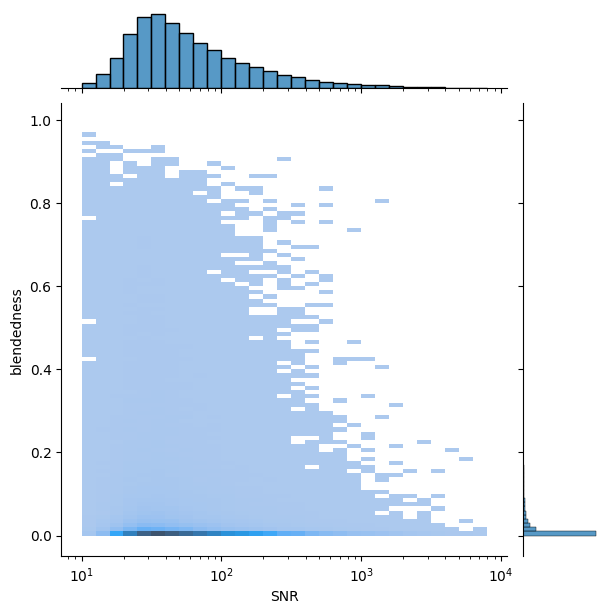

In [ ]:
g = sns.JointGrid()
x_bins = np.arange(1,4,.10)
y_bins = np.arange(0.00, 1, .01)
sns.histplot(x=madness_results['r_band_snr'].values, y=madness_results['r_blendedness'].values, ax=g.ax_joint, bins=[x_bins, y_bins], log_scale=[True, False], kde=True)
g.ax_joint.set_xlabel("SNR")
g.ax_joint.set_ylabel("blendedness")
sns.histplot(x=madness_results['r_band_snr'].values, ax=g.ax_marg_x, bins=x_bins, kde_kws={'clip': (0,500)})
sns.histplot(y=madness_results['r_blendedness'].values, ax=g.ax_marg_y, bins=y_bins)

<AxesSubplot:xlabel='Count'>

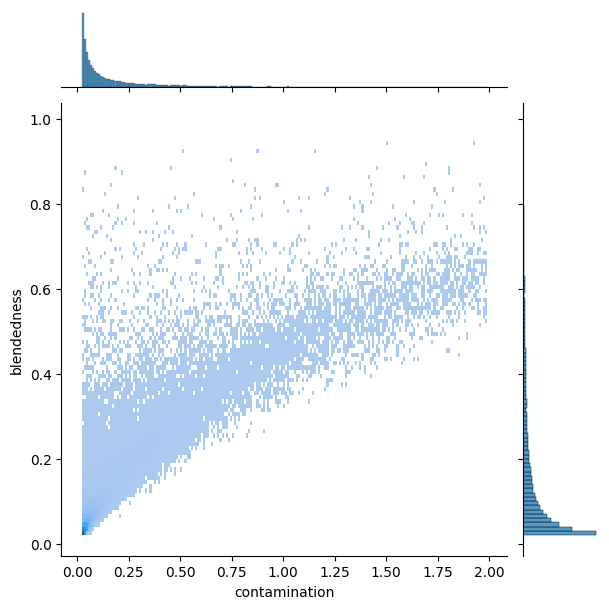

In [ ]:
g = sns.JointGrid()
x_bins = np.arange(.02, 2, .01)
y_bins = np.arange(0.02, 1, .01)
sns.histplot(x=madness_results['r_contamination'].values, y=madness_results['r_blendedness'].values, ax=g.ax_joint, bins=[x_bins, y_bins], log_scale=[False, False], kde=True)
g.ax_joint.set_xlabel("contamination")
g.ax_joint.set_ylabel("blendedness")
sns.histplot(x=madness_results['r_contamination'].values, ax=g.ax_marg_x, bins=x_bins, kde_kws={'clip': (0,500)})
sns.histplot(y=madness_results['r_blendedness'].values, ax=g.ax_marg_y, bins=y_bins)

# 

<AxesSubplot:xlabel='Count'>

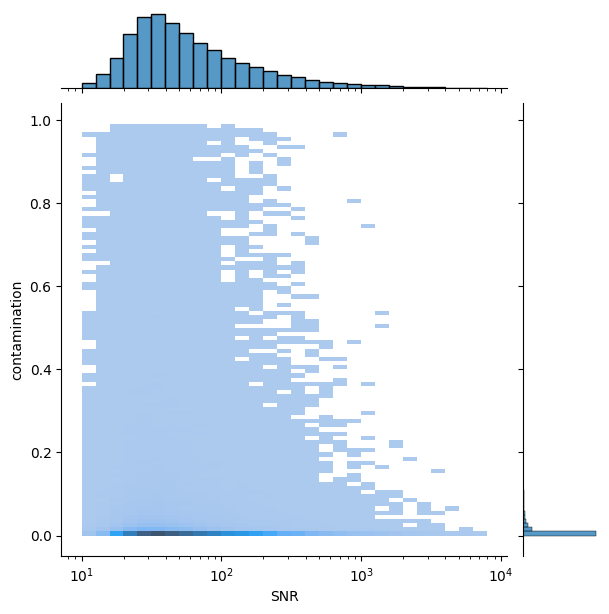

In [ ]:
g = sns.JointGrid()
x_bins = np.arange(1,4,.10)
y_bins = np.arange(0.00, 1, .01)
sns.histplot(x=madness_results['r_band_snr'].values, y=madness_results['r_contamination'].values, ax=g.ax_joint, bins=[x_bins, y_bins], log_scale=[True, False], kde=True)
g.ax_joint.set_xlabel("SNR")
g.ax_joint.set_ylabel("contamination")
sns.histplot(x=madness_results['r_band_snr'].values, ax=g.ax_marg_x, bins=x_bins, kde_kws={'clip': (0,500)})
sns.histplot(y=madness_results['r_contamination'].values, ax=g.ax_marg_y, bins=y_bins)

Plot for u band


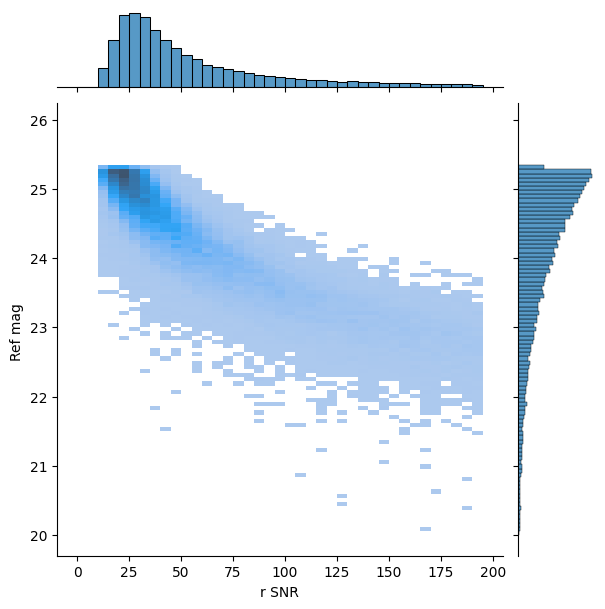

Plot for g band


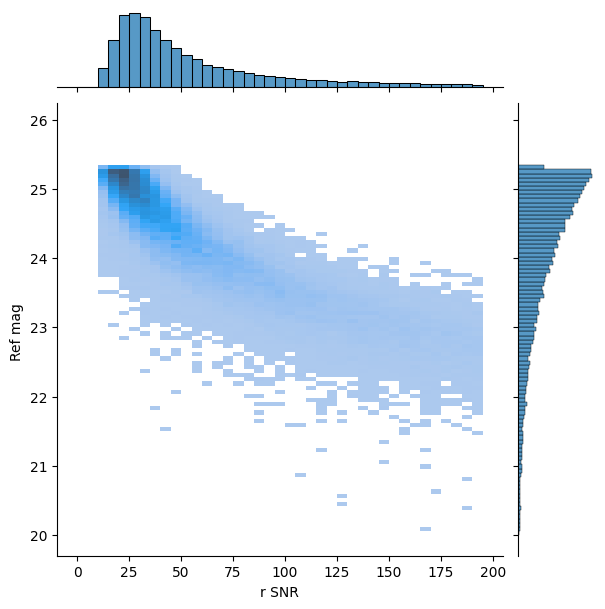

Plot for r band


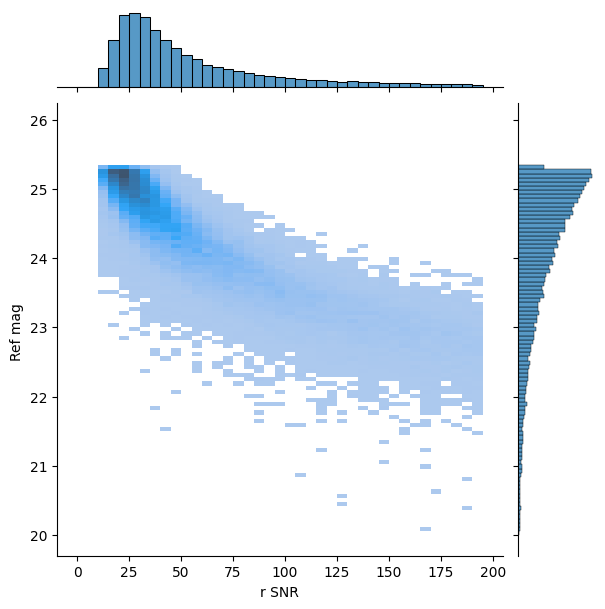

Plot for i band


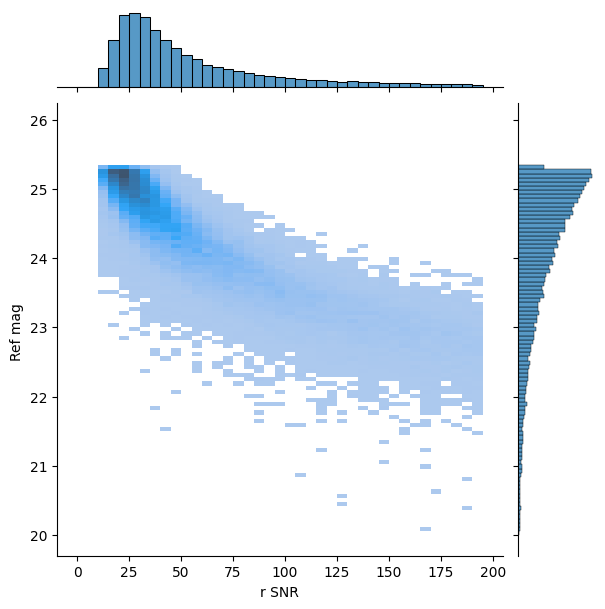

Plot for z band


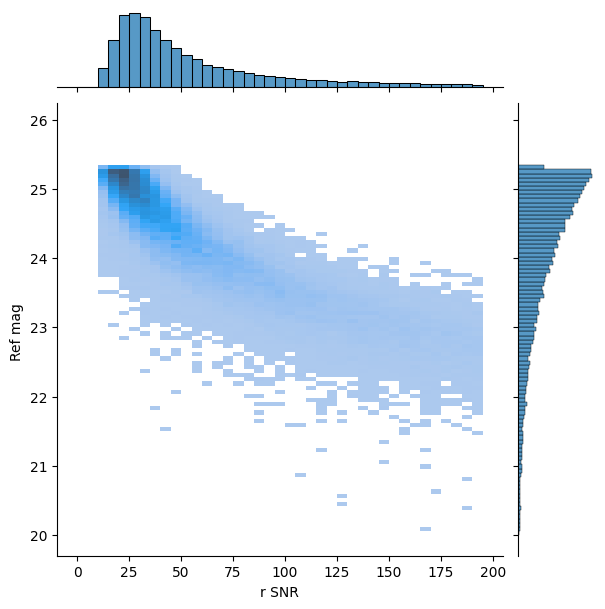

Plot for y band


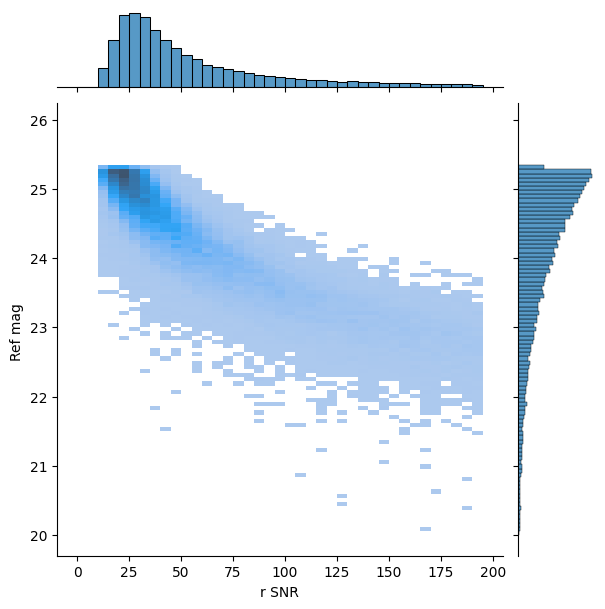

In [ ]:
for band_num, band in enumerate(['u', 'g', 'r', 'i', 'z', 'y']):
    print(f"Plot for {band} band")
    #snr = actual_photometry[band+"_phot_flux"].values / actual_photometry[band+"_phot_fluxerrs"].values
    snr = madness_results["r_band_snr"].values
    # mag = madness_results["ref_mag"].values
    #h = plt.hist2d(snr, madness_results[band+ "_relative_flux_err"], bins=30, cmin=2, range=[[0, 6], [-.4, .4]])
    x_bins = np.arange(0,200,5.0)
    y_bins = np.arange(20, 26, 6/100.0)
    #sns.histplot(x=snr, y=madness_results["ref_mag"], bins=[x_bins, y_bins], kde=False, cbar=True)
    g = sns.JointGrid()
    sns.histplot(x=snr, y=madness_results["ref_mag"].values, bins=[x_bins, y_bins], kde=False, ax=g.ax_joint)
    g.ax_joint.set_xlabel("r SNR")
    g.ax_joint.set_ylabel("Ref mag ")
    sns.histplot(x=snr, ax=g.ax_marg_x, bins=x_bins, kde_kws={'clip': (0,500)})
    sns.histplot(y=madness_results["ref_mag"].values, ax=g.ax_marg_y, bins=y_bins)
    #ax.set(xlabel='SNR', ylabel='Ref Mag '+band)
    
    plt.show()